# 🏋️ Model Training

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import gc
import time
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import torch
from torch import nn
import wandb
from pprint import pprint
import warnings

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.chdir("../../")
warnings.filterwarnings("ignore")
load_dotenv()

True

Importing user defined packages

In [3]:
from lib.config import config
from lib.paths import Paths
from lib.model.epoch_functions import train_epoch, valid_epoch
from lib.model.utils import get_score, get_model_optimizer_and_scheduler
from lib.utils.utils import seed_everything
from lib.data_tools.data import read_data_loader_from_disk
from lib.criterion.metrics import log_metrics

In [4]:
pprint(config)

namespace(apex=True,
          batch_scheduler=True,
          batch_size_train=32,
          batch_size_valid=32,
          betas=[0.9, 0.999],
          data_version=2,
          debug=False,
          decoder_lr=2e-05,
          encoder_lr=2e-05,
          epochs=2,
          eps=1e-06,
          gradient_accumulation_steps=1,
          gradient_checkpointing=True,
          lgbm_a=2.998,
          lgbm_b=1.092,
          lgbm_n_folds=15,
          max_grad_norm=1000,
          max_length=512,
          min_lr=1e-06,
          model='microsoft/deberta-v3-large',
          n_folds=7,
          negative_sample=False,
          negative_sample_partitions=3,
          num_classes=6,
          num_cycles=0.5,
          num_warmup_steps=0,
          num_workers=6,
          positive_classes=[0, 5],
          negative_classes=[1, 2, 3, 4],
          print_freq=6,
          random_seed=20,
          regression=False,
          scheduler='cosine',
          stride=192,
          tokenizer_ve

In [5]:
seed_everything()

### Setting Up WandB

In [6]:
WANDB_PROJECT = "Kaggle_ASE_2.0"
model_name = config.model.split("/")[-1]
WANDB_NAME = f"{model_name}-{config.max_length}-D{config.data_version}-T{config.tokenizer_version}"

In [7]:
wandb.login(key=os.environ.get('WANDB_API_KEY'))
wandb.init(
    project=WANDB_PROJECT,
    name=WANDB_NAME,
    save_code=True,
    job_type="train",
    config=config,
)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shakleenishfar (laplacesdemon43). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ishfar/.netrc


## 📖 Definitions

### 🌎 Global Variables

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The competition data has a class imbalance problem. Which is why I assign higher weights to classes having lower samples.

In [9]:
# class_weights = torch.tensor([1.0, 0.25, 0.25, 0.5, 1.0, 2.0]).to(device)
class_weights = torch.tensor([1.0] * 6).to(device)

### 🛠️ Functions

In [10]:
def train_loop(fold):
    print(f"========== Fold: {fold} training ==========")

    # ======== DATA LOADER ==========
    train_loader, valid_loader = read_data_loader_from_disk(fold)
    valid_fold = pd.read_csv(os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv"))
    valid_labels = valid_fold["score"].values

    # ======== MODEL ==========
    model, optimizer, scheduler = get_model_optimizer_and_scheduler(
        train_loader, device
    )

    # ======= LOSS ==========
    # criterion = RMSELoss(reduction="mean") # nn.SmoothL1Loss(reduction='mean')
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    softmax = nn.Softmax(dim=1)

    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.epochs):
        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(
            fold,
            train_loader,
            model,
            criterion,
            optimizer,
            epoch,
            scheduler,
            device,
        )

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(
            fold, valid_loader, model, criterion, device
        )
        predictions = prediction_dict["predictions"]
        _, pred_scores = torch.max(softmax(torch.tensor(predictions)), dim=1)

        # ======= SCORING ==========
        score = get_score(valid_labels, pred_scores)

        wandb.log(
            {
                f"eval/eval_epoch_f{fold}": epoch + 1,
                f"eval/eval_loss_f{fold}": avg_val_loss,
                f"eval/qwk_score_f{fold}": score,
            }
        )

        elapsed = time.time() - start_time

        print(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        print(f"Epoch {epoch+1} - Score: {score:.4f}")

        if score > best_score:
            best_score = score
            print(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "predictions": predictions},
                os.path.join(
                    Paths.MODEL_OUTPUT_PATH,
                    f"{config.model.replace('/', '_')}_fold_{fold}_best.pth",
                ),
            )

    predictions = torch.load(
        Paths.MODEL_OUTPUT_PATH
        + f"/{config.model.replace('/', '_')}_fold_{fold}_best.pth",
        map_location=torch.device("cpu"),
    )["predictions"]
    predictions = softmax(torch.tensor(predictions))
    _, pred_scores = torch.max(predictions, dim=1)
    valid_fold["pred_score"] = pred_scores

    for i in range(config.num_classes):
        valid_fold[f"score_prob_{i}"] = predictions[:, i]

    del model, optimizer, scheduler, criterion, softmax
    torch.cuda.empty_cache()
    gc.collect()

    return valid_fold

In [11]:
def get_result(oof_df):
    labels = oof_df["score"].values
    preds = oof_df["pred_score"].values
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')
    return score

## 🏁 Start Training

In [12]:
if config.train:
    oof_df = pd.DataFrame()

    for fold in range(config.n_folds):
        if fold in config.train_folds:
            _oof_df = train_loop(fold)
            log_metrics(_oof_df, f"Fold {fold}")
            oof_df = pd.concat([oof_df, _oof_df])
            print(f"========== Fold: {fold} result ==========")
            get_result(_oof_df)

    oof_df = oof_df.reset_index(drop=True)
    print(f"========== CV ==========")
    score = get_result(oof_df)
    wandb.log({"CV/qwk_score": score})
    oof_df.to_csv(Paths.MODEL_OUTPUT_PATH + "/oof_df.csv", index=False)

========== Fold: 0 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 0: 100%|██████████| 126/126 [02:27<00:00,  1.17s/valid_batch]


Epoch 1 - avg_train_loss: 0.9870  avg_val_loss: 0.9157  time: 1457s
Epoch 1 - Score: 0.8180
Epoch 1 - Save Best Score: 0.8180 Model


Validating Fold 0: 100%|██████████| 126/126 [02:29<00:00,  1.19s/valid_batch]


Epoch 2 - avg_train_loss: 0.7667  avg_val_loss: 0.9618  time: 1428s
Epoch 2 - Score: 0.8211
Epoch 2 - Save Best Score: 0.8211 Model
========== Fold: 0 result ==========
Score: 0.8211
========== Fold: 1 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 1: 100%|██████████| 122/122 [02:21<00:00,  1.16s/valid_batch]


Epoch 1 - avg_train_loss: 0.9806  avg_val_loss: 1.1978  time: 1382s
Epoch 1 - Score: 0.7291
Epoch 1 - Save Best Score: 0.7291 Model


Validating Fold 1: 100%|██████████| 122/122 [02:22<00:00,  1.17s/valid_batch]


Epoch 2 - avg_train_loss: 0.7170  avg_val_loss: 1.1371  time: 1418s
Epoch 2 - Score: 0.7754
Epoch 2 - Save Best Score: 0.7754 Model
========== Fold: 1 result ==========
Score: 0.7754
========== Fold: 2 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 2: 100%|██████████| 109/109 [01:58<00:00,  1.08s/valid_batch]


Epoch 1 - avg_train_loss: 0.9711  avg_val_loss: 1.0406  time: 1331s
Epoch 1 - Score: 0.7045
Epoch 1 - Save Best Score: 0.7045 Model


Validating Fold 2: 100%|██████████| 109/109 [02:07<00:00,  1.17s/valid_batch]


Epoch 2 - avg_train_loss: 0.7284  avg_val_loss: 1.0638  time: 1427s
Epoch 2 - Score: 0.7055
Epoch 2 - Save Best Score: 0.7055 Model
========== Fold: 2 result ==========
Score: 0.7055
========== Fold: 3 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 3: 100%|██████████| 58/58 [01:01<00:00,  1.06s/valid_batch]


Epoch 1 - avg_train_loss: 0.9798  avg_val_loss: 1.2611  time: 1416s
Epoch 1 - Score: 0.4573
Epoch 1 - Save Best Score: 0.4573 Model


Validating Fold 3: 100%|██████████| 58/58 [01:01<00:00,  1.06s/valid_batch]


Epoch 2 - avg_train_loss: 0.7454  avg_val_loss: 1.0809  time: 1363s
Epoch 2 - Score: 0.6442
Epoch 2 - Save Best Score: 0.6442 Model
========== Fold: 3 result ==========
Score: 0.6442
========== Fold: 4 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 4: 100%|██████████| 154/154 [02:47<00:00,  1.09s/valid_batch]


Epoch 1 - avg_train_loss: 1.0178  avg_val_loss: 0.8589  time: 1285s
Epoch 1 - Score: 0.7444
Epoch 1 - Save Best Score: 0.7444 Model


Validating Fold 4: 100%|██████████| 154/154 [02:47<00:00,  1.09s/valid_batch]


Epoch 2 - avg_train_loss: 0.7234  avg_val_loss: 0.9575  time: 1285s
Epoch 2 - Score: 0.7268
========== Fold: 4 result ==========
Score: 0.7444
========== Fold: 5 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 5: 100%|██████████| 82/82 [01:28<00:00,  1.08s/valid_batch]


Epoch 1 - avg_train_loss: 0.9854  avg_val_loss: 1.2806  time: 1364s
Epoch 1 - Score: 0.6748
Epoch 1 - Save Best Score: 0.6748 Model


Validating Fold 5: 100%|██████████| 82/82 [01:28<00:00,  1.08s/valid_batch]


Epoch 2 - avg_train_loss: 0.7317  avg_val_loss: 1.7435  time: 1344s
Epoch 2 - Score: 0.6293
========== Fold: 5 result ==========
Score: 0.6748
========== Fold: 6 training ==========


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Validating Fold 6: 100%|██████████| 96/96 [01:53<00:00,  1.18s/valid_batch]


Epoch 1 - avg_train_loss: 0.9622  avg_val_loss: 1.0603  time: 1340s
Epoch 1 - Score: 0.7461
Epoch 1 - Save Best Score: 0.7461 Model


Validating Fold 6: 100%|██████████| 96/96 [01:53<00:00,  1.18s/valid_batch]


Epoch 2 - avg_train_loss: 0.7397  avg_val_loss: 0.9853  time: 1387s
Epoch 2 - Score: 0.8090
Epoch 2 - Save Best Score: 0.8090 Model
========== Fold: 6 result ==========
Score: 0.8090
========== CV ==========
Score: 0.7776


In [13]:
wandb.log({"oof_table": wandb.Table(dataframe=oof_df)})

## Evaluate

In [14]:
log_metrics(oof_df, "Overall")

### Confusion Matrix

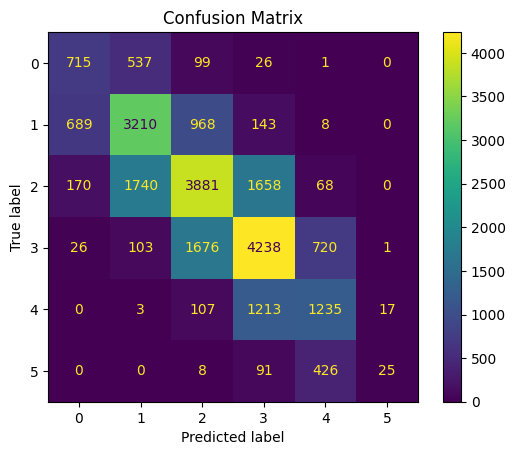

In [15]:
cm = confusion_matrix(oof_df["score"], oof_df["pred_score"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(config.num_classes)))

# Plot the confusion matrix
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix")
plt.show()

Finish experiment

In [17]:
wandb.finish()